In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import cv2 as cv
import numpy as np
from utils.io_utils import get_cam_images, output_stereo_calib_results, draw_stereo_pair, draw_stereo_pair_detections
from utils.calib_utils import detect_keypoints, check_neigh_consistency, check_stereo_orientation

## Basler0 to Basel1

In [6]:
pattern_size = (8, 6)
data_path0 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera0"
data_path1 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera1"

images0 = get_cam_images(data_path0)
images1 = get_cam_images(data_path1)

In [26]:
results0 = detect_keypoints(images0, pattern_size)
results1 = detect_keypoints(images1, pattern_size)

In [27]:
# idx = 0 

In [28]:
# draw_stereo_pair(images0, images1, idx)
# draw_stereo_pair_detections(images0, images1, results0, results1, pattern_size, idx)

# idx += 1

In [29]:
basler0_intrinsincs = np.load('calib_output/basler0_intrinsincs.npy', allow_pickle=True).item()
basler1_intrinsincs = np.load('calib_output/basler1_intrinsincs.npy', allow_pickle=True).item()

In [30]:
intrinsics0 = basler0_intrinsincs['intrinsics']
dist_coeff0 = basler0_intrinsincs['dist_coeff']

intrinsics1 = basler1_intrinsincs['intrinsics']
dist_coeff1 = basler1_intrinsincs['dist_coeff']

In [33]:
results0 = check_neigh_consistency(results0, pattern_size)
results1 = check_neigh_consistency(results1, pattern_size)

In [37]:
shape = images0[0].shape[::-1][1:]

scene_points, loc_kp0, loc_kp1 = check_stereo_orientation(results0, results1, pattern_size, 3.0)

reproj_error01, _, _, _, _, R01, T01, E01, F01 = cv.stereoCalibrate(scene_points, loc_kp0, loc_kp1, 
                                                                    intrinsics0, dist_coeff0, 
                                                                    intrinsics1, dist_coeff1,
                                                                    shape, flags=cv.CALIB_FIX_INTRINSIC)

print(reproj_error01)

0.32009619799666533


R:
[[ 0.99996749 -0.00149425 -0.00792423]
 [ 0.00150245  0.99999834  0.00102884]
 [ 0.00792268 -0.00104071  0.99996807]]
T:
[[-1.72881029]
 [-0.02646029]
 [-0.28409584]]
E:
[[ 2.17204381e-04  2.84122909e-01 -2.61671517e-02]
 [-2.70389802e-01 -1.37468274e-03  1.73100634e+00]
 [ 2.38619691e-02 -1.72884696e+00 -1.98834633e-03]]
F:
[[-9.71619074e-09 -1.27106140e-05  9.95436890e-03]
 [ 1.21014803e-05  6.15295156e-08 -1.79636374e-01]
 [-9.39415758e-03  1.79333739e-01  1.00000000e+00]]
Saved calibration results as calib_output/basler0_basler1_extrinsics.npy


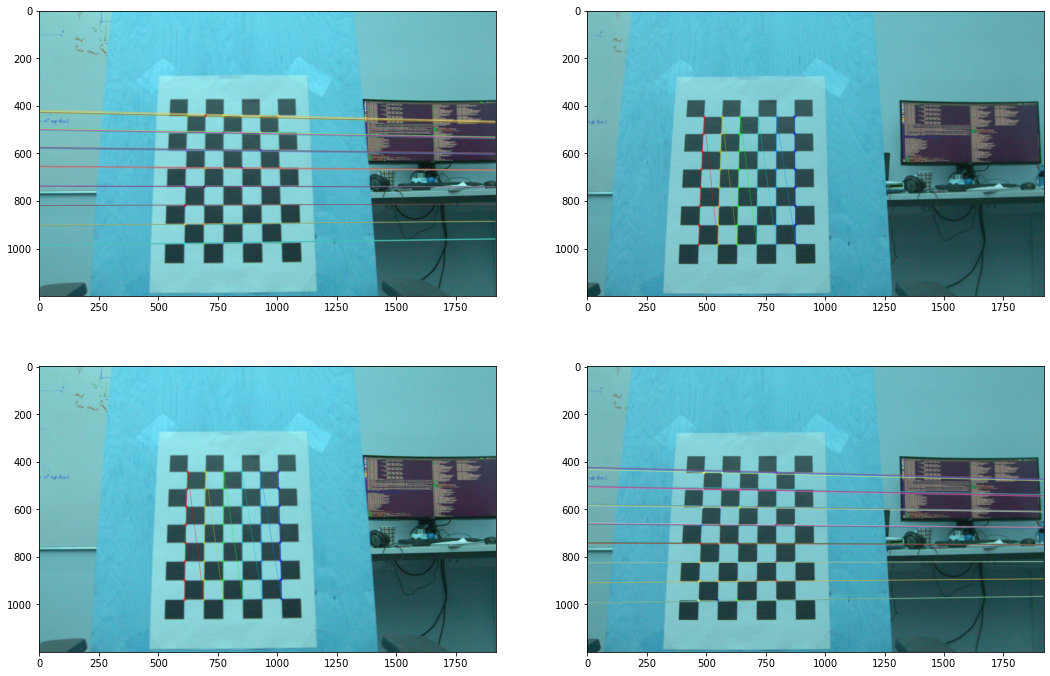

In [38]:
output_stereo_calib_results(R01, T01, E01, F01, images0, images1, results0, results1, pattern_size, 0, "output/basler0_basler1")

## Basler0 to Samsung

In [33]:
image_names0 = ['1605628353112004352.jpg',
                '1605628358912127232.jpg',
                '1605628364911643136.jpg',
                '1605628369911900416.jpg',
                '1605628376112852224.jpg',
                '1605628380111790592.jpg',
                '1605628388711998464.jpg']

image_names_s = ['1301142278530082.jpg',
                 '1301148277753155.jpg',
                 '1301154276967035.jpg',
                 '1301160276183569.jpg',
                 '1301164942237335.jpg',
                 '1301170274874331.jpg',
                 '1301177607251287.jpg']

In [34]:
data_path0 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera0"
data_path_s = "/home/konstantin/datasets/bandeja-sequence/samsung/20201117_185235_CHESS"

images0 = get_cam_images(data_path0, file_name_list=image_names0)
images_s = get_cam_images(data_path_s, file_name_list=image_names_s)

In [35]:
results0 = detect_keypoints(images0, pattern_size)
results_s = detect_keypoints(images_s, pattern_size)

In [36]:
# idx = 0 

In [37]:
# draw_stereo_pair(images0, images1, idx)
# draw_stereo_pair_detections(images0, images1, results0, results1, pattern_size, idx)

# idx += 1

In [38]:
basler0_intrinsincs = np.load('calib_output/basler0_intrinsincs.npy', allow_pickle=True).item()
samsung_intrinsincs = np.load('calib_output/samsung_intrinsincs.npy', allow_pickle=True).item()

In [39]:
intrinsics0 = basler0_intrinsincs['intrinsics']
dist_coeff0 = basler0_intrinsincs['dist_coeff']

intrinsics_s = samsung_intrinsincs['intrinsics']
dist_coeff_s = samsung_intrinsincs['dist_coeff']

In [43]:
shape = images1[0].shape[::-1][1:]

scene_points, loc_kp0, loc_kp_s = check_stereo_orientation(results0, results_s, pattern_size, 60.0)

reproj_error0s, _, _, _, _, R0s, T0s, E0s, F0s = cv.stereoCalibrate(scene_points, loc_kp0, loc_kp_s, 
                                                                    intrinsics0, dist_coeff0, 
                                                                    intrinsics_s, dist_coeff_s,
                                                                    shape, flags=cv.CALIB_FIX_INTRINSIC)

print(reproj_error0s)

0.9170083919162908


R:
[[ 0.99984767  0.00527815  0.01663687]
 [-0.00561756  0.9997757   0.02042058]
 [-0.01652536 -0.02051092  0.99965305]]
T:
[[-3.59224354]
 [ 1.38418326]
 [ 3.45070325]]
E:
[[-3.48958580e-03 -3.47832012e+00  1.31323766e+00]
 [ 3.39081448e+00 -5.54668901e-02  3.64840611e+00]
 [-1.36379275e+00 -3.59874372e+00 -9.63841640e-02]]
F:
[[ 2.26682647e-09  2.25967911e-06 -3.16848433e-03]
 [-2.21899359e-06  3.63010059e-08 -3.06222938e-03]
 [ 2.18812746e-03  1.40315630e-03  1.00000000e+00]]
Saved calibration results as calib_output/basler0_samsung_extrinsics.npy


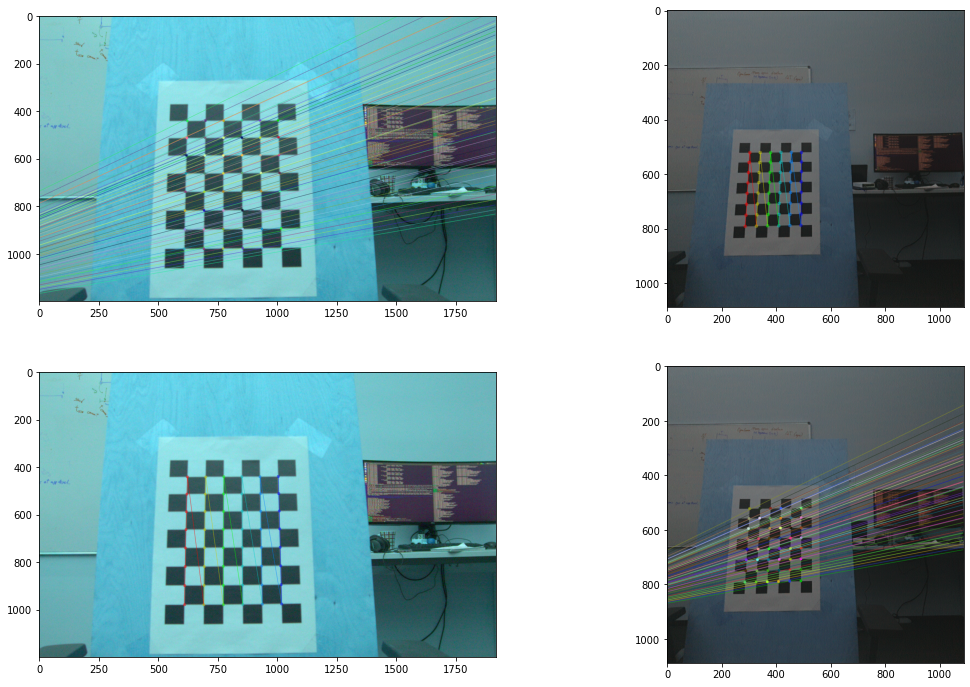

In [44]:
output_stereo_calib_results(R0s, T0s, E0s, F0s, images0, images_s, results0, results_s, pattern_size, 0, "output/basler0_samsung")